<a href="https://colab.research.google.com/github/Hrithik2212/CV-for-Self-Driving-Car/blob/main/00_RCNN_Heavy_Vehicle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heavy Vehicle Detection 


In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install torch-snippets
!pip install selectivesearch

In [4]:
import torch
from torch_snippets import *
import selectivesearch
from google.colab import files
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Data Wrangling 

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

kaggle.json
100% 366M/367M [00:03<00:00, 153MB/s]
100% 367M/367M [00:03<00:00, 117MB/s]


## Data Exploration and Preparation 

In [6]:
df = pd.read_csv('/content/df.csv')
df.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24062 entries, 0 to 24061
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageID      24062 non-null  object 
 1   Source       24062 non-null  object 
 2   LabelName    24062 non-null  object 
 3   Confidence   24062 non-null  int64  
 4   XMin         24062 non-null  float64
 5   XMax         24062 non-null  float64
 6   YMin         24062 non-null  float64
 7   YMax         24062 non-null  float64
 8   IsOccluded   24062 non-null  int64  
 9   IsTruncated  24062 non-null  int64  
 10  IsGroupOf    24062 non-null  int64  
 11  IsDepiction  24062 non-null  int64  
 12  IsInside     24062 non-null  int64  
 13  XClick1X     24062 non-null  float64
 14  XClick2X     24062 non-null  float64
 15  XClick3X     24062 non-null  float64
 16  XClick4X     24062 non-null  float64
 17  XClick1Y     24062 non-null  float64
 18  XClick2Y     24062 non-null  float64
 19  XCli

In [8]:
df.columns

Index(['ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin',
       'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction',
       'IsInside', 'XClick1X', 'XClick2X', 'XClick3X', 'XClick4X', 'XClick1Y',
       'XClick2Y', 'XClick3Y', 'XClick4Y'],
      dtype='object')

In [9]:
image_data_dir = '/content/images/images'

class Bus_Truck_DataSet(Dataset):
  def __init__(self, df ,img_root = image_data_dir):
    self.root = img_root 
    self.df = df
    self.unique_imgs = df['ImageID'].unique()

  def __len__(self): return len(self.unique_imgs)

  def __getitem__(self , ix ):
    image_id = self.unique_imgs[ix]
    image_path = f'{self.root}/{image_id}.jpg'
    # convert to BGR to RGB 
    img = cv2.imread(image_path,1)[...,::-1]
    h , w , _ = img.shape
    df = self.df.copy()
    df = df[df['ImageID'] == image_id]
    boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
    boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
    classes = df['LabelName'].values.tolist()
    return img , boxes , classes , image_path

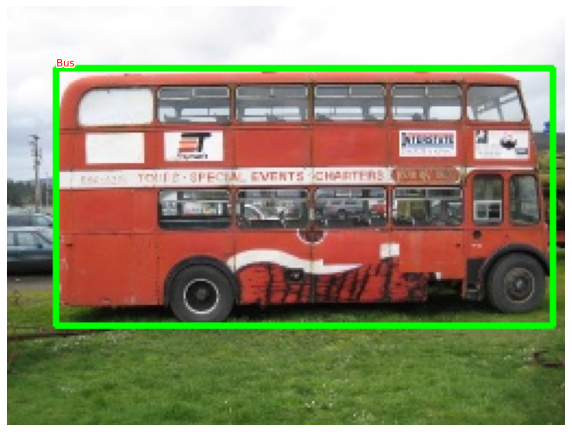

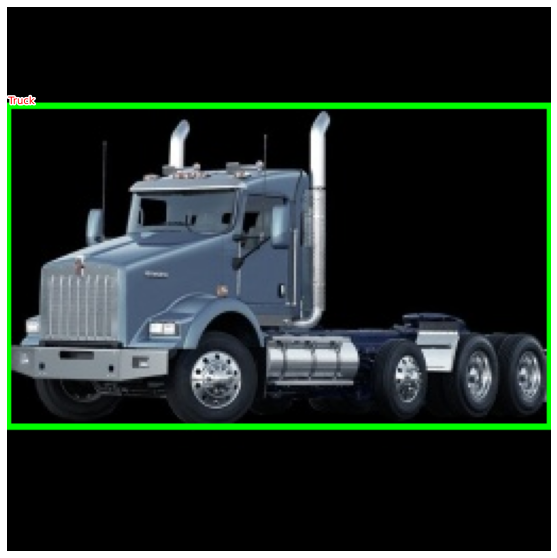

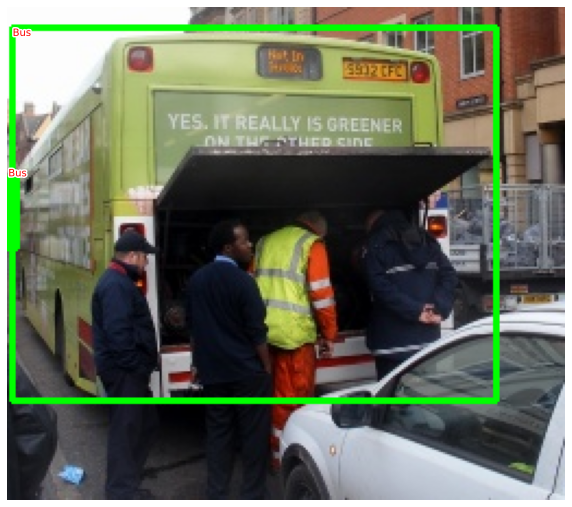

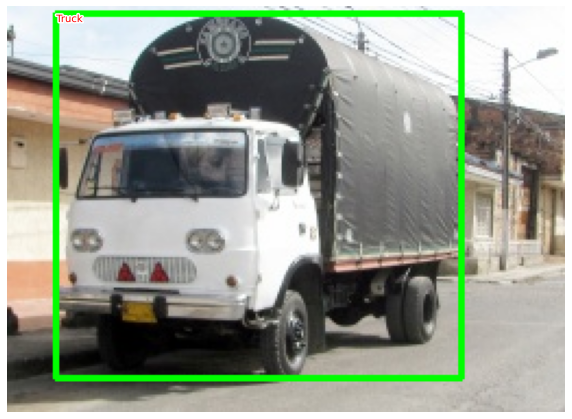

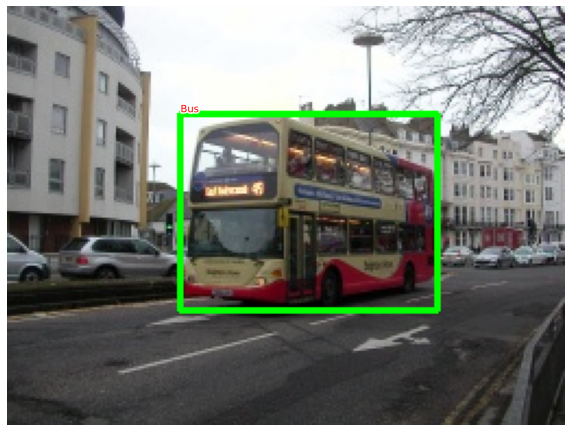

In [10]:
data = Bus_Truck_DataSet(df)
for i in range(100,105):
  im, bbs, clss, _ = data[i]
  show(im, bbs=bbs, texts=clss, sz=10)

In [11]:
def extract_candidates(img):
  img_lbl , regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  img_area = np.prod(img.shape[:2])
  candidates = []
  for r in regions:
    if r['rect'] in candidates: continue
    if r['size'] < (0.05*img_area): continue
    if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))
  return candidates

def extract_iou(boxA, boxB, epsilon=1e-5):
  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])
  width = (x2 - x1)
  height = (y2 - y1)
  if (width<0) or (height <0):
    return 0.0
  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  area_combined = area_a + area_b - area_overlap
  iou = area_overlap / (area_combined+epsilon)
  return iou

In [12]:
''' 
file paths(FPATHS), 
ground truth bounding
boxes (GTBBS), 
classes (CLSS) of objects, 
the delta offset of a bounding box with region proposals (DELTAS), 
region proposal locations (ROIS), and 
the IoU of region proposals with ground truths (IOUS)
'''

' \nfile paths(FPATHS), \nground truth bounding\nboxes (GTBBS), \nclasses (CLSS) of objects, \nthe delta offset of a bounding box with region proposals (DELTAS), \nregion proposal locations (ROIS), and \nthe IoU of region proposals with ground truths (IOUS)\n'

In [13]:
len(data)

15225

In [14]:
FPATHS , GTBBS , CLSS , DELTAS , ROIS , IOUS = [] , [] , [] , [] , [] , []

In [15]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(data):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{image_data_dir}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [19]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']